In [1]:
import torch
import monai
from glob import glob
from monai.transforms import Compose
from pathlib import Path
import torchio as tio
import os
from tqdm import tqdm
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import monai.networks
import monai.networks.nets
from dataset import DeepLesionDataset
from model import get_model
from sklearn.decomposition import PCA

/home/moonsurfer/miniconda3/envs/medicaldino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1221/1221 [05:39<00:00,  3.60it/s]


Running t-SNE...


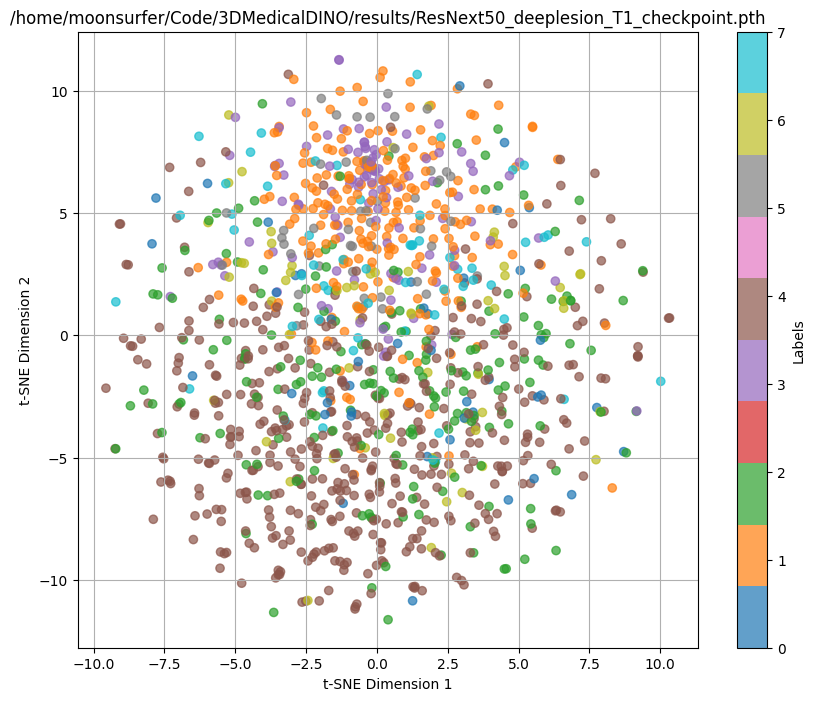

100%|██████████| 1221/1221 [05:02<00:00,  4.04it/s]


Running t-SNE...


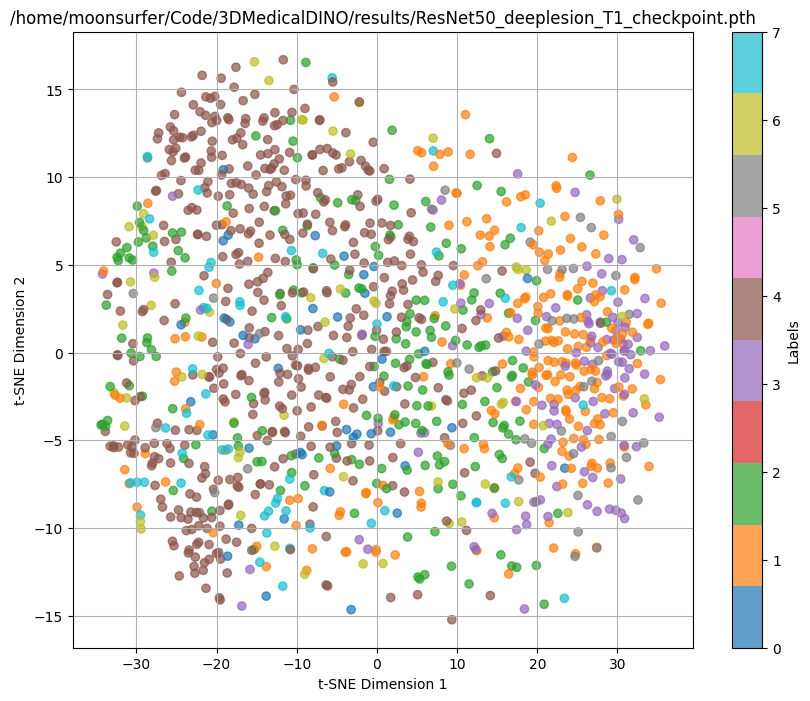

In [2]:
path = "/home/moonsurfer/Code/foundation-cancer-image-biomarker/data/preprocessing/deeplesion/annotations/task1_test.csv"

for model_name in ["ResNext50", "ResNet50"]:
    for sequence in ["deeplesion"]:    

        dataset = DeepLesionDataset(args=None, path=path, transform="inference", radius=25)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=1) 

        for checkpoint_path in glob(f"/home/moonsurfer/Code/3DMedicalDINO/results/{model_name}*checkpoint.pth"):
            _, model, _ = get_model(model_name=model_name, sequence=sequence)
            model.load_state_dict(torch.load(checkpoint_path, weights_only=False)["teacher"], strict=False)
            model.cuda()

            features = []
            labels = []
            dims = []
            df = pd.read_csv(path)

            for volume, filepath in tqdm(dataloader):                

                file_id = filepath[0].split("/")[-1]
                label = df[df["Volume_fn"] == file_id]["Coarse_lesion_type"].iloc[0].item()
                volume = volume.to(torch.float32).cuda()
                out = model(volume) 
                labels.append(label)
                features.append(out.detach().cpu())                

            features = torch.concatenate(features)        
            labels = torch.from_numpy(np.array(labels))            

            data_np = features.cpu().numpy()
            labels_np = labels.cpu().numpy()

            # Perform t-SNE to reduce dimensionality to 2D
            print("Running t-SNE...")
            tsne = TSNE(n_components=2, perplexity=30, random_state=42)
            data_2d = tsne.fit_transform(data_np)

            # Visualization
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels_np, cmap="tab10", alpha=0.7)
            plt.colorbar(scatter, ticks=range(8), label="Labels")
            plt.title(f"{checkpoint_path}")
            plt.xlabel("t-SNE Dimension 1")
            plt.ylabel("t-SNE Dimension 2")
            plt.grid(True)
            plt.show()

    